In [7]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime

In [ ]:
# Change matplotlob parameters including figure size, font size and dpi
# import matplotlib as plt
# plt.rcParams['font.size']=12
# plt.rcParams['savefig.dpi'] = 120
# plt.rcParams['figure.figsize']=(8.0,6.0)

In [452]:
products = pd.read_csv('new_result.csv', sep=',')
reviews = pd.read_csv("reviews.csv")

In [5]:
products.head()

,product_id,product_name,product_brand,product_detail,product_description,product_price,product_sale,weight,photo_num,best_seller_rank,water_proof,noise_cancel,micro_phone,review_num,review_rate
0,B012N7X65S,Trendwoo Runner X9 Bluetooth 4.0 Wireless Ster...,Trendwoo,Enter your model number above to make sure thi...,Features: Specifications: Model: Runner X9 Blu...,39.99,0.00,82.213617,7,2318,1,0,0,228,3.7
1,B016OADE1Q,"Bluetooth 4.1 Headphones,LADEY Wireless Blueto...",LADEY,"Bluetooth 4.1,support volume control,it also c...","Sweatproof design,best choice when you do spor...",44.29,14.26,861.825503,7,9289,1,1,0,0,0.0
2,B005IYDFVO,Clarity CE50 HearIt Mobile Bluetooth Neckloop,Clarity,Clarity CE50 Purchase Includes:CE50 hand-free ...,"Wireless, hands-free communication for Bluetoo...",0.00,0.00,340.194277,1,10653,0,0,1,6,3.0
3,B017RDCZ1Y,PowerLead S200 Bluetooth 4.1 Sport Gym Running...,PowerLead,Premuim high quality CSR chip allows this head...,Product fetures: It's a high end smart sports ...,56.87,40.54,8.504857,7,8379,0,1,0,11,4.5
4,B01AHYVC8M,Car MP3 Player Transmissor FM sem fio Dual USB...,Love Lover,"Can charge mobile phones, never worry about po...",Product description: - Can charge mobile phone...,0.00,0.00,NaN,5,8473,0,1,1,0,0.0


In [6]:
reviews.head()

,id,pid,author,rate,title,content,date,verified,color,vote
0,R2FVGLARZJG07Z,B012N7X65S,Amazon Customer,1,Would not buy again,These worked great for about 2 days. Then they...,2016-4-17,1,Blue,0
1,R3REA8NAIKAM81,B012N7X65S,Kevin S,1,Overheated While Charging,"A couple months after using only a few times, ...",2016-4-10,1,Blue,1
2,R3GEDQ48VESB50,B012N7X65S,romancereader243,5,Five Stars,Very easy to handle,2016-4-10,1,Blue,0
3,R2ZL7XB9BDB5SP,B012N7X65S,Harry Schwartz,3,good for price,For the price they are alright. They have a pi...,2016-4-9,1,Blue,0
4,R1PXUFQXRVS5EB,B012N7X65S,MajorTom007,1,Never buy Trendwoo. Never Buy from TopBrandBo...,"After light use only 3-4 hours a week, the hea...",2016-3-31,1,Red,0


### 資料預處理：
Amazon上有很多商品是一樣的，但是由於顏色不同造成商品編號不同，因此我們以**商品名稱**作為標準把這些**商品單一化**，商品由 10,628 個降到 8,217 個。評論也是如此，原先有 603,545 筆，單一化之後變成 291,949 筆。

In [567]:
products = products.drop_duplicates("product_name")
reviews = reviews.drop_duplicates("id")

由於有些商品沒有特價只有原價，或有些商品沒有原價只有特價，就會分別遺失 **product_sale** 和 **product_price** 的值，因此我們要把遺失的資料補齊。接著重新檢查資料，剛剛 **product_price** 或是 **product_sale** 只有其中一個值 為 0 的商品應該都已經不是 0 了。如果還有這種情況的商品代表它沒有標上任何價格，代表商家並不打算販售該產品，可能是缺貨或是作為展示用途，因此把它們去掉。

In [458]:
def cleanPrice(row):
    if row["product_price"] * row["product_sale"] == 0:
        row["product_price"], row["product_sale"] = max(row["product_price"],row["product_sale"]), max(row["product_price"],row["product_sale"])
    return row
products = products.apply(cleanPrice, axis=1)
products = products[products["product_price"] > 0]
products["review_rateXnum"] = products["review_num"] * products["review_rate"] / products["review_num"].mean()

---

#Summary

####於是我們便成功得到了以下參數的總數、平均值、標準差、最大最小值與中位數。
* 商品原價 (product_price) 
* 商品售價 (product_sale) 
* 評價數量 (review_num) 
* 評價分數 (review_rate) 
* 評價分數乘以數量 (review_rateXnum)

In [772]:
products[["product_price","product_sale","review_num","review_rate","review_rateXnum"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
product_price,8217,52.653376,48.917806,0.25,20.00000,39.990000,69.990000,699.990000
product_sale,8217,40.120629,46.024699,0.25,15.99000,25.000000,49.900000,699.990000
review_num,8217,55.685773,120.485887,0.00,1.00000,10.000000,47.000000,975.000000
review_rate,8217,3.072691,1.655485,0.00,2.70000,3.600000,4.200000,5.000000
review_rateXnum,8217,3.732703,8.065350,0.00,0.08979,0.678809,3.165979,73.435274


###價錢：
我們可以從以上的結果得知藍牙耳機的總數有 8217 隻，價位區間從 \$0.25 - \$699.99，**商品原價**平均為 \$52.7，**商品(實)售價**平均為 \$40.1，折扣佔了原價的 24%。**商品售價**低於 $50 的藍芽耳機佔了總數的 75% 左右，意即藍芽耳機是一個**低價競爭的市場**。

[[<matplotlib.axis.XTick at 0x2827d6c10>,
 (0, 200),

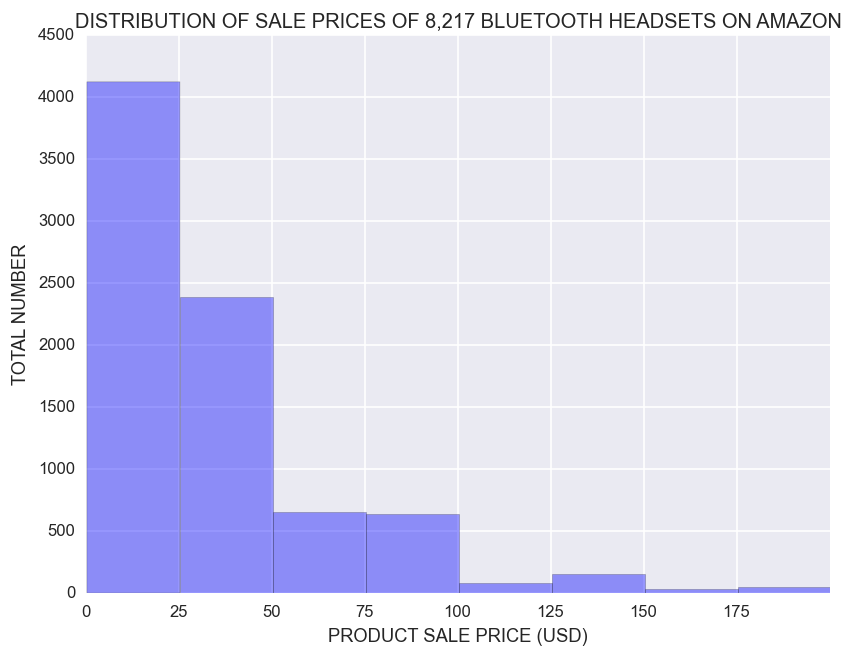

In [768]:
ps = sns.distplot(products.product_sale, kde=False, bins=28.5, color="b")
ps.set(xticks=range(0,200,25), xlim=(0,200), xlabel='PRODUCT SALE PRICE (USD)', ylabel='TOTAL NUMBER', title="DISTRIBUTION OF SALE PRICES OF 8,217 BLUETOOTH HEADSETS ON AMAZON")

###評論分數：
每個商品平均會有 56 個評論，但是平均分數並不是 3.07 分，因為 **review_rate** 已經是每個商品評論總數的平均分數，所以不能直接拿來做平均。必須將評論分數與評論數量相乘之後再除以評論平均數才能取得真正的平均值。計算出來的結果高達 3.7 分，這個分數可以作為往後購買 Amazon 藍牙耳機的依據，在 Amazon 購買藍牙耳機前如果發現該商品的的總體分數小於 **3.7** 分，就能猜測它是一項有問題的商品。

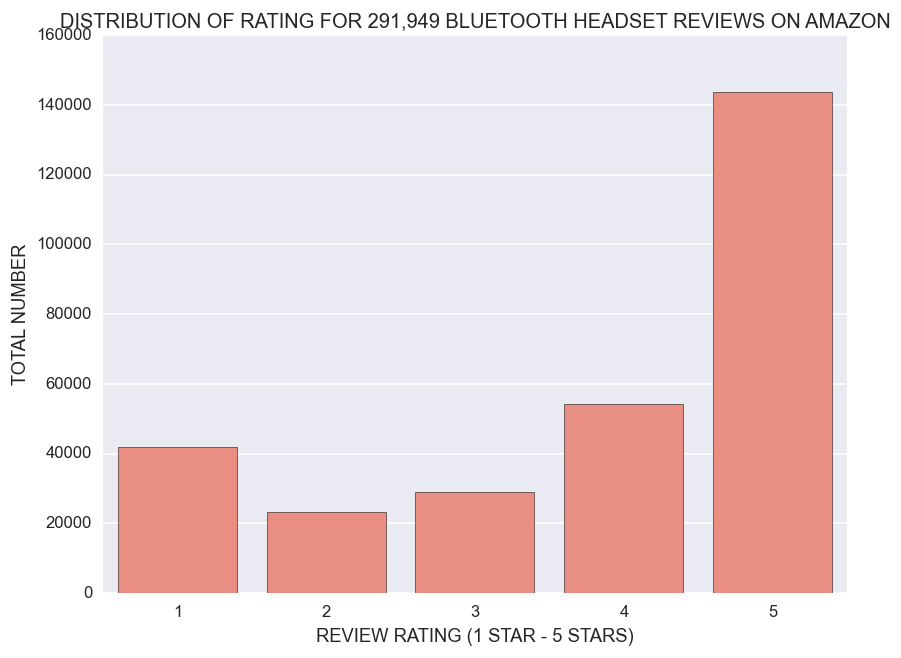

In [746]:
rc = sns.countplot(reviews.rate, color="salmon")
rc.set(xlabel='REVIEW RATING (1 STAR - 5 STARS)', ylabel='TOTAL NUMBER', title="DISTRIBUTION OF RATING FOR 291,949 BLUETOOTH HEADSET REVIEWS ON AMAZON")

上圖呈現了分別對藍牙耳機所有評論評分由 1 至 5 分別做出的加總，可知超過半數的人給了購買的商品 5 星評價，接下來則是 4 星和 1 星，只有極少數評價給予 3 星和 2 星。

###趨勢
現代人越來越重視健康而運動，許多人喜歡在跑步、騎腳踏車或是健身房運動時戴上耳機，享受與自己的對話。藍牙耳機比起有線耳機先天上有著較佳安全性與配戴感的優勢，因應這股運動風潮，藍牙耳機的功能越趨多元，目前主打的三大功能為麥克風(37%)、防噪音(27%)以及劇烈運動時非常重要的防水(9%)功能：

In [766]:
products[["micro_phone","noise_cancel","water_proof"]].mean().apply(lambda x: "{0}%".format(int(round(x,2)*100)))

micro_phone     37%
noise_cancel    27%
water_proof      9%
dtype: object

#評論分析

**商品評論是網路購物旅程中很重要的一環。**
讓我們假設一個情境來說明，使用者A在網路上看到了一項商品後很想購買，但是因為沒有摸到實品而感到猶豫，這時候假如看到了使用者B寫的推薦評論而決定購買，實際使用了之後可能會出現以下三種情境：
1. 不管好不好用都沒有打算在網路上寫出對商品的想法
2. 覺得商品不錯，並且感謝使用者B的推薦，為了讓更多人知道這個產品很棒，決定在網路上分享正評
3. 根本和使用者B描述的不同，為了避免其他人也因為不實評論留下不好經驗，決定到網路上建議不要購買

###評論字數分布

[[<matplotlib.axis.XTick at 0x176f28f90>,
 (0, 1000),

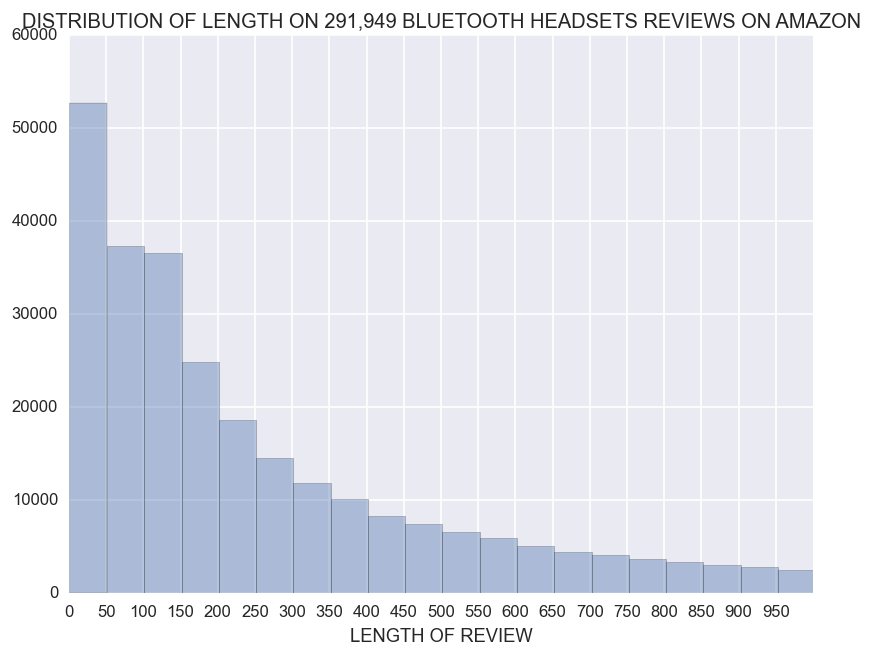

In [777]:
reviews["review_length"] = reviews["content"].apply(lambda x: len(str(x)))
cl = sns.distplot(reviews["content"].apply(lambda x: len(str(x))), kde=False, bins=441)
cl.set(xticks=range(0,1000,50), xlim=(0, 1000), xlabel='LENGTH OF REVIEW', title="DISTRIBUTION OF LENGTH ON 291,949 BLUETOOTH HEADSETS REVIEWS ON AMAZON")

In [785]:
print "評論字數小於200字的比例為: %.2f%%，大於等於200字的比例為: %.2f%%，字數平均為: %s 個字" % (float(len(reviews[reviews["review_length"] < 200]))/len(reviews)*100, float(len(reviews[reviews["review_length"] >= 200]))/len(reviews)*100, int(reviews["review_length"].mean()))

評論字數小於200字的比例為: 51.56%，大於等於200字的比例為: 48.44%，字數平均為: 394 個字


由上圖與計算式可知 50 個字是大部份的人願意留下評論的字數，但是以 200 字為分界，以下和以上的評論比例分別是51.56% 和 48.44%。這個結果顯示，雖然不知道購買產品之後願意動手寫評論的比例有多少，但是寫下評論的人中約有一半願意在 Amazon 這個平台寫下超過 200 字的想法。

這樣的購物生態形成一個不斷強化的信賴圈：
* 對消費者而言，能在網路上發表自己的想法，買到更適合自己產品的機率也變高了，何樂而不為?
* 對商家而言，消費者的評論不但是免費的行銷還是賺錢的關鍵，從他們口中理解產品缺點，並且挖掘他們對產品的想像，才能讓銷售長紅。
* 對 Amazon 而言，只要消費者和商家都在這個平台都獲得滿足，產生良性循環，鈔票就會不斷流進口袋！

台灣前幾大的電商如 PChome、Gohappy、Yahoo 購物中心比較強調的都是商品種類、價錢、物流，沒有一個是重視消費者評論的，反倒是不那麼主流的電商如 Pinkoi 可以抓住這個點培養出一群願意分享的忠實粉絲，擴張版圖。

###評論隨著時間序列推進越來越好
由下圖可知 2000-2004 評價分數的震盪幅度很大，推測這是因為當時藍牙耳機商品數量不多，評論的樣本數不夠大所造成的偏差。近幾年的評價有越來越高的趨勢，這不見得代表販售耳機的商家越來越能抓住消費者的胃口，也有可能是因為網路寫手越來越多的關係，這個假設會在後面被證實。

In [ ]:
reviews['date'] = reviews['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
ts = reviews[["date","rate"]]
ts["year-month"] = ts.loc[:,"date"].apply(lambda x: x.strftime("%Y-%m"))
ts["month"] = ts.loc[:,"date"].apply(lambda x: x.month)
ts["weekday"] = ts.loc[:,"date"].apply(lambda x: x.strftime("%A"))

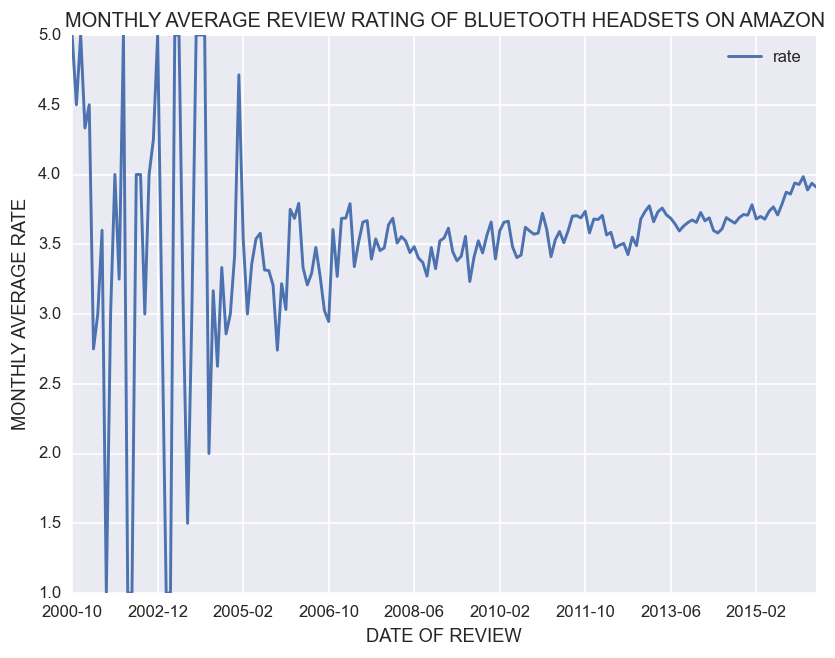

In [639]:
ymr = ts[["year-month","rate"]].groupby("year-month").mean().plot()
ymr.set(xlabel="DATE OF REVIEW",ylabel="MONTHLY AVERAGE RATE ", title="MONTHLY AVERAGE RATING OF BLUETOOTH HEADSETS ON AMAZON")

###夏天評價差，冬天評價好？
把每個月份於各年的歷史資料進行平均之後發現了這個驚人的事實，藍牙耳機在冬天的評價分數比起夏天還來的好，這或許是因為夏天時配戴藍牙耳機運動，很容易讓耳機因為進水、受潮而縮短壽命，因此評價分數會略低一些。

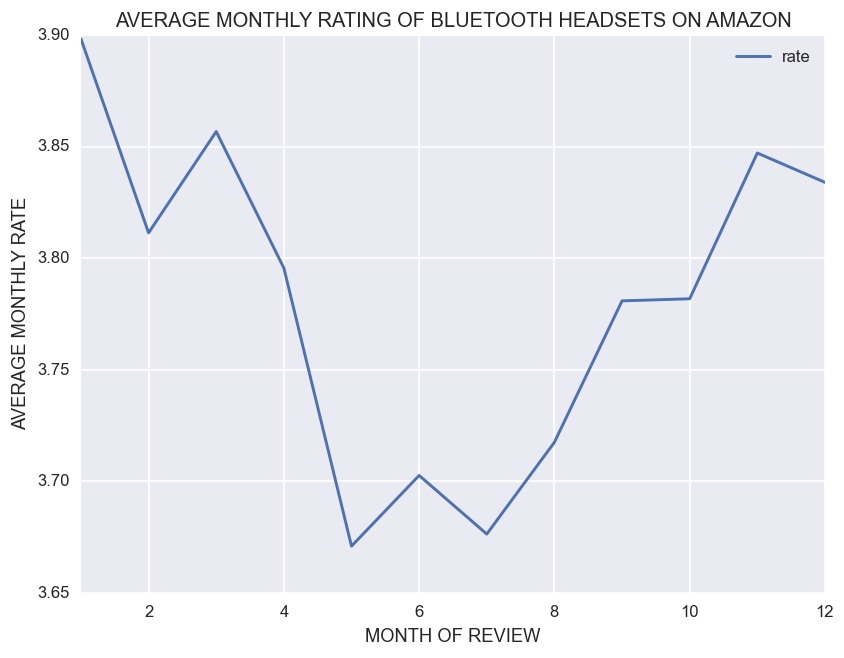

In [641]:
mr = ts[["month","rate"]].groupby("month").mean().plot()
mr.set(xlabel="MONTH OF REVIEW",ylabel="AVERAGE MONTHLY RATE", title="AVERAGE MONTHLY RATING OF BLUETOOTH HEADSETS ON AMAZON")

---
###藍牙耳機的售價與評價分數沒有關係
假設評價與銷售量有正相關，商家在競爭激烈的價格區間推出新耳機時，或許會對訂價感到困擾，訂價較區間平均高一點會不會讓消費者覺得CP值不夠，而得到較差的評價。事實上商品售價與評價分數的相關係數只有0.045，他們之間並沒有什麼關係。商家應該專注於品質管控、售後服務、消費者意見回饋才能累積信譽，賺取長久的獲利。

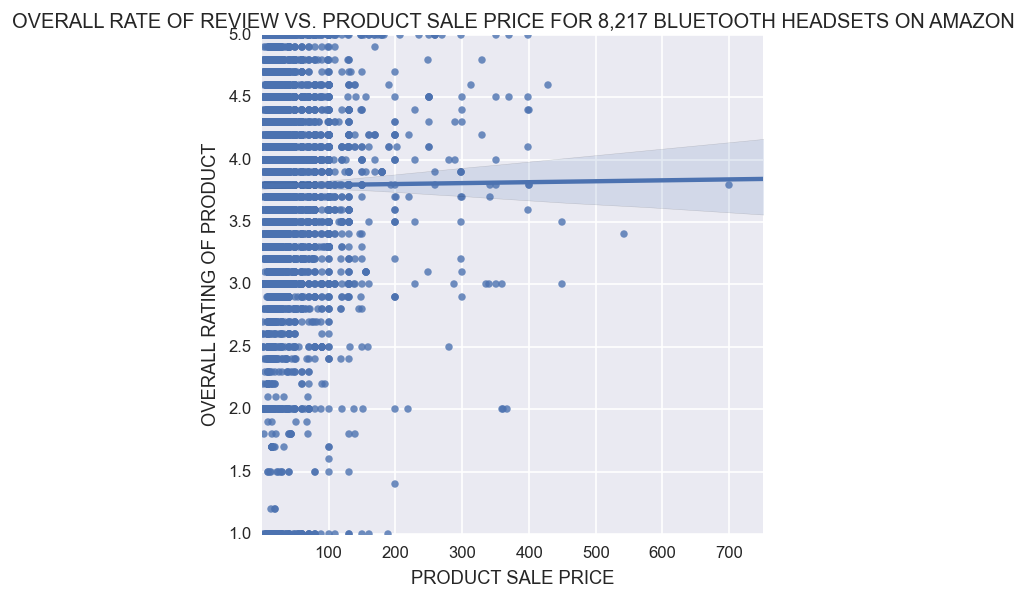

In [659]:
psrr_lmp = sns.lmplot(x="product_sale", y="review_rate", data=products[products["review_rate"] > 0])
psrr_lmp.set(xlim=(1,750),ylim=(1,5),xlabel='PRODUCT SALE PRICE', ylabel='OVERALL RATING OF PRODUCT', title="OVERALL RATE OF REVIEW VS. PRODUCT SALE PRICE FOR 8,217 BLUETOOTH HEADSETS ON AMAZON")

In [643]:
products[products["product_sale"] > 0][["review_rate","product_sale"]].corr()

,review_rate,product_sale
review_rate,1.000000,0.045241
product_sale,0.045241,1.000000


###商品敘述越詳細，會讓商品得較高評價
商品敘述的平均字數為 610 個字（包含標點符號與空格），**商品敘述字數**與**評價分數**這兩個參數的相關性為 0.15 左右，因此推測商品敘述的文字越多會稍微影響到消費者的評價。理論上來說商家對商品描述得越詳細，消費者的認知落差就越小，但是最重要的還是據實詳述產品功能，華而不實的文字所帶來的效益依然有限。

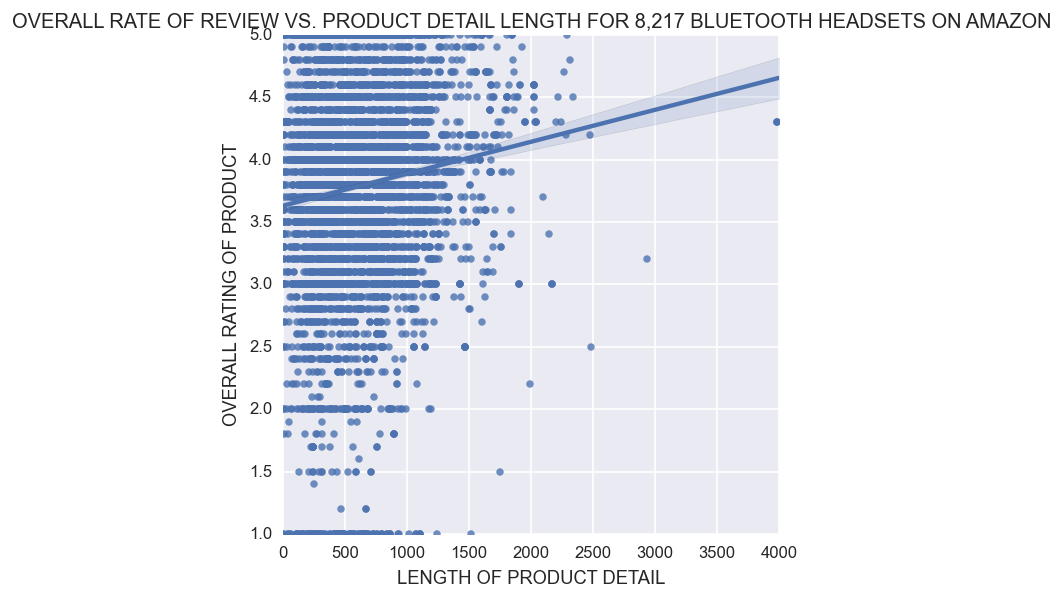

In [749]:
products["detail_length"] = products["product_detail"].apply(lambda x: len(str(x)))
rl_lmp = sns.lmplot(x="detail_length", y="review_rate", data=products[products["review_rate"] > 0])
rl_lmp.set(xlim=(0,4000),ylim=(1,5),xlabel='LENGTH OF PRODUCT DETAIL', ylabel='OVERALL RATING OF PRODUCT', title="OVERALL RATE OF REVIEW VS. PRODUCT DETAIL LENGTH FOR 8,217 BLUETOOTH HEADSETS ON AMAZON")

In [755]:
print"商品描述平均字數: %.2f (字)" % (products["detail_length"].mean())

商品描述平均字數: 609.94 (字)


In [752]:
products[["review_rate","detail_length"]].corr()

,review_rate,detail_length
review_rate,1.000000,0.149893
detail_length,0.149893,1.000000


---
# Amazon Review System Problem
###這個平台上的評價可信度有多高?

Amazon 的評價系統最近也遇到了一個問題，由於藍牙耳機的競爭過於激烈，某些商家為了在眾多耳機中脫穎而出，採取了兩種策略：
1. 體驗策略：以體驗的名義贈送耳機給一群特定的網路寫手，以免費的耳機換取5顆星的好評。
2. 低價策略：在特定時間將耳機降到 \$1 以下，讓消費者以近乎免費的價格購入價值遠低於售價的耳機，對於如此便宜的商品人們的標準相對會降低，給予比起以一般價格購入的消費者還高的評價。

某些商家就是透過體驗與短期低價策略，衝高商品評價，獲取更多消費者的青睞，但是這就苦了想要在網路上購物的消費者。Amazon 的評論機制是這樣運作的，不論有沒有在 Amazon 上購買該商品都可以在該商品頁面留下評論，因為它認為就算消費者能夠購買商品的管道太多了，只要有使用的經驗就可以留下寶貴的意見供人參考，目的是為了建立一個完備的評論系統。但是為了不讓商家的體驗策略太過猖獗，系統會判斷留下評論的人是否曾經在 Amazon 上夠過過該產品，如果確實有購買紀錄就會在評論旁邊加上 <span style="color:#c45500;">Verified Purchase</span> 的標籤。沒有這個標籤的評論不全然屬於業配文，但是當中的一部分確實過度誇大商品的功能，降低平台的可信度。

這個標籤是一個非常好的特徵供我們用來驗證某些商家為了衝評分而採取的手段。
接下來為了分析方便將 **products** 與 **reviews** 這兩個 DataFrame **合併(Merge)**起來，分析評價與是否有 Verified Purchase 標籤相關性，並且將藍牙耳機以實際售價分成3個等級，觀察這兩個變數的相關性在不同價錢區間是否會有所不同：
<table style="margin-left:0px">
    <tr>
        <td><strong>FROM</strong></td>
        <td><strong>TO</strong></td>
        <td><strong>CLASS</strong></td>
        <td><strong>CORRELATION</strong></td>
    </tr>
    <tr>
        <td>\$0</td>
        <td>\$50</td>
        <td style=text-align:center>LOW</td>
        <td style=text-align:center>-0.24</td>
    </tr>
    <tr>
        <td>\$51</td>
        <td>\$100</td>
        <td style=text-align:center>MID</td>
        <td style=text-align:center>-0.24</td>
    </tr>
    <tr>
        <td>\$101</td>
        <td>\$700</td>
        <td style=text-align:center>HIGH</td>
        <td style=text-align:center>0.10</td>
    </tr>
</table>



In [664]:
reviews["product_id"] = reviews["pid"]
rgpid_mean = reviews.groupby("product_id").mean().reset_index()
merged_df = pd.merge(products, rgpid_mean, on='product_id', how='inner')
def assignClass(price):
    if price < 51:
        return "LOW"
    elif price < 101:
        return "MID"
    else:
        return "HIGH"
merged_df["Class"] = merged_df["product_sale"].apply(assignClass)

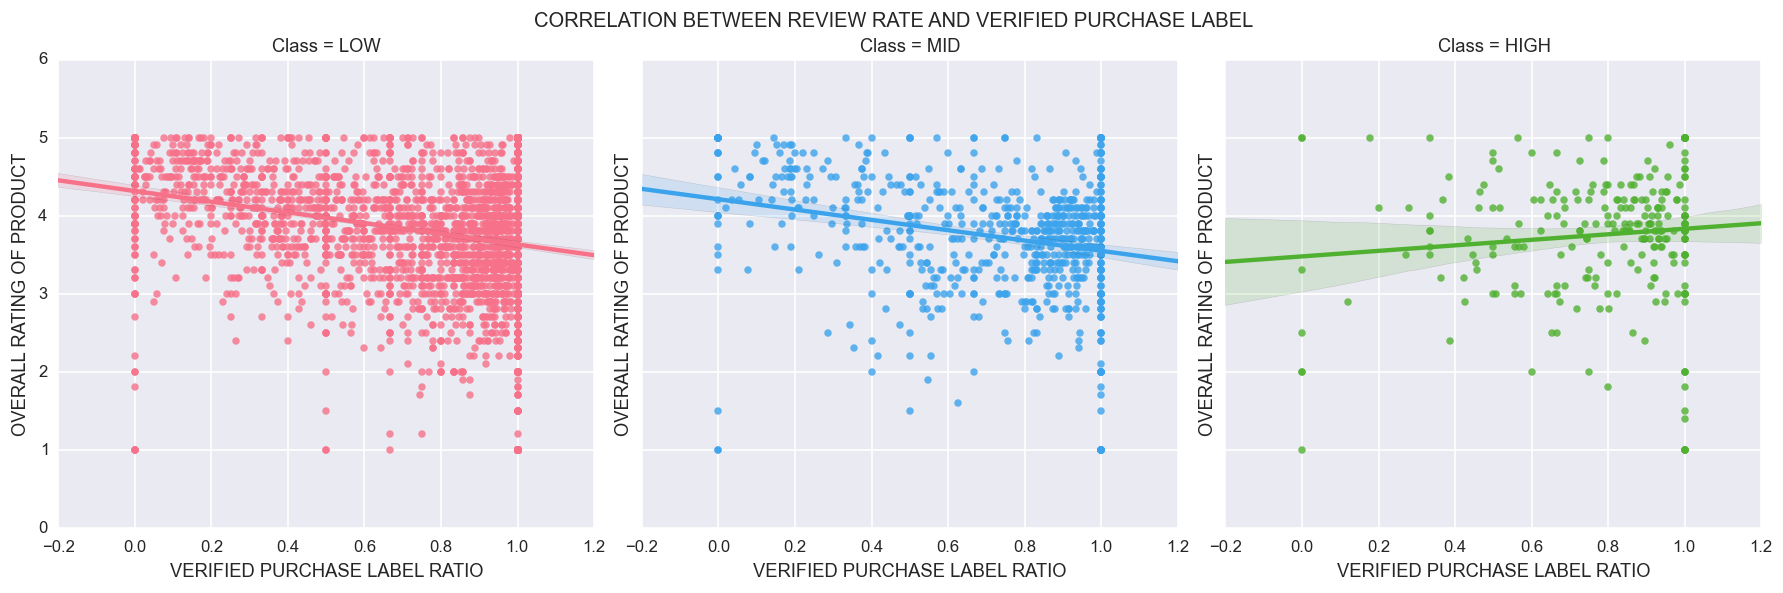

In [712]:
vrh = sns.lmplot(data=merged_df, x="verified", y="review_rate", col="Class", hue="Class",  palette="husl", col_order=["LOW","MID","HIGH"])
vrh.set(xlabel="VERIFIED PURCHASE LABEL RATIO", ylabel="OVERALL RATING OF PRODUCT")
plt.subplots_adjust(top=0.9)
vrh.fig.suptitle("CORRELATION BETWEEN REVIEW RATE AND VERIFIED PURCHASE LABEL")

In [714]:
l_corr = merged_df[merged_df["Class"]=="LOW"][["review_rate","verified"]].corr()["review_rate"]["verified"]
m_corr = merged_df[merged_df["Class"]=="MID"][["review_rate","verified"]].corr()["review_rate"]["verified"]
h_corr = merged_df[merged_df["Class"]=="HIGH"][["review_rate","verified"]].corr()["review_rate"]["verified"]
all_corr = merged_df[["review_rate","verified"]].corr()["review_rate"]["verified"]
print "CORRELATION BETWEEN REVIEW RATE AND VERIFIED PURCHASE LABEL:\nLOW CLASS   %.2f\nMID CLASS   %.2f\nHIGH CLASS   %.2f\nALL         %.2f" % (l_corr, m_corr, h_corr, all_corr)

CORRELATION BETWEEN REVIEW RATE AND VERIFIED PURCHASE LABEL:
LOW CLASS   -0.24
MID CLASS   -0.24
HIGH CLASS   0.10
ALL         -0.22


由上述結果可以得知在售價低於 $100 競爭相對激烈的藍牙耳機市場，較容易發生上述現象，造成沒有 Amazon 購買認證(Verified Purchase)的商品平均評價會比有認證的還高，消費者若是要購買該價格區間的商品要特別注意。本專案便是為了解決這種問題而出現的，透過資料的收集與分析幫助消費者買到評價較無偏差的產品。

---

#商家分析(未完成)

#文字分析

In [728]:
from sklearn.feature_extraction.text import CountVectorizer
import operator
import sys
count = CountVectorizer()
name_np = products["product_name"].values
name_bag = count.fit_transform(name_np)
# print(count.vocabulary_)
sorted_x = sorted(count.vocabulary_.items(), key=operator.itemgetter(1))

In [729]:
t=re.split('\W+',sys.stdin.read().lower())
r=sorted(count.vocabulary_ for w in set(t)if w not in'andithetoforinis')[:22]

In [730]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Feelings/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [731]:
t=re.split('\W+',name_np.dumps())
r=sorted((-t.count(w),w)for w in set(t)if w not in stop)
fr = r[:50]
for l,w in fr:print(78-len(fr[0][1]))*l/fr[0][0]*'=',w

===================================================================== Bluetooth
========================================== Wireless
======================================= U
==================================== Headset
========================== Stereo
======================= Headphones
==================== r
=================== 4
================= Samsung
================ iPhone
============== Headphone
============= Earbuds
============= Black
============ 6
============ Sports
============ 0
============ Microphone
=========== Earphone
========== Galaxy
========== 1
========= Ear
========= Android
========= Sport
========= Mic
========= Noise
========= Hands
======== 3
======== Earphones
======== Music
======= 2
======= Running
======= Mini
======= LG
====== 5
====== iPad
====== In
====== Headsets
===== free
===== Smart
===== Phones
===== Universal
===== For
===== Sweatproof
===== Free
===== Note
===== Cancelling
===== Plus
===== HTC
===== Gym
===== S5


#SIMILAR PORDUCT - KNN MODEL

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
np.set_printoptions(precision=2)
print(tfidf.fit_transform(count.fit_transform(name_np)).toarray())

In [ ]:
#graphlab
import graphlab
gf = graphlab.SFrame('pd_result.csv')

In [15]:
gf['detail_tfidf'] = graphlab.text_analytics.tf_idf(gf['product_detail'])
gf['description_tfidf'] = graphlab.text_analytics.tf_idf(gf['product_description'])

In [17]:
knn_model = graphlab.nearest_neighbors.create(gf, features=['detail_tfidf','description_tfidf'], label='product_id')

Starting brute force nearest neighbors model training.

Defaulting to brute force instead of ball tree because there are multiple distance components.


In [18]:
knn_model.query(gf[gf['product_id']=='B012N7X65S'])

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.0106598   | 16.482ms     |

| Done         |         | 100         | 70.992ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,B012N7X65S,0.0,1
0,B012N7WVW2,0.0,2
0,B015W1SY1I,1.23811107416,3
0,B015W1SWRE,1.23811107416,4
0,B015W1SVH0,1.23811107416,5


In [21]:
knn_mixed_model = graphlab.nearest_neighbors.create(gf, features=['detail_tfidf','description_tfidf','water_proof','noise_cancel','micro_phone'], label='product_id')

Starting brute force nearest neighbors model training.

Defaulting to brute force instead of ball tree because there are multiple distance components.


In [20]:
knn_mixed_model.query(gf[gf['product_id']=='B012N7X65S'])

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.0106598   | 23.708ms     |

| Done         |         | 100         | 84.273ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,B012N7X65S,0.0,1
0,B012N7WVW2,0.0,2
0,B015W1SY1I,1.23811107416,3
0,B015W1SWRE,1.23811107416,4
0,B015W1SVH0,1.23811107416,5


In [26]:
#add price feature

In [25]:
#normalization
gf["normalized_sale"] = gf["product_sale"] - gf["product_sale"].min() / gf["product_sale"].max() - gf["product_sale"].min()

In [23]:
knn_mixed_model = graphlab.nearest_neighbors.create(gf, features=['detail_tfidf','description_tfidf','water_proof','noise_cancel','micro_phone','normalized_sale'], label='product_id')

Starting brute force nearest neighbors model training.

Defaulting to brute force instead of ball tree because there are multiple distance components.


In [24]:
knn_mixed_model.query(gf[gf['product_id']=='B012N7X65S'])

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.0106598   | 25.151ms     |

| Done         |         | 100         | 97.112ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,B012N7X65S,0.0,1
0,B012N7WVW2,0.0,2
0,B00VLMUSPS,1.72049637479,3
0,B015E1OUOQ,1.77570876684,4
0,B015E1OLH2,1.77570876684,5
